In [ ]:
import torch
import lightning as L
import numpy as np
import matplotlib.pyplot as plt

from src.jepa import JEPA
from src.data.dataset import PointMazeTransitions


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [4]:
dataset = PointMazeTransitions("data/train_trajectories_small.npz", frame_size=(128, 128))

[Dataset] Frames resized to 128×128
[Dataset] Loaded 10 episodes, 1000 transitions.
[Dataset] Frame shape: (128, 128, 3)


In [ ]:
jepa = JEPA.load_from_checkpoint("checkpoints/jepa/last-v7.ckpt")
jepa.to(device)
jepa.eval();

In [5]:
(state, frame), action, (next_state, next_frame) = dataset[100]

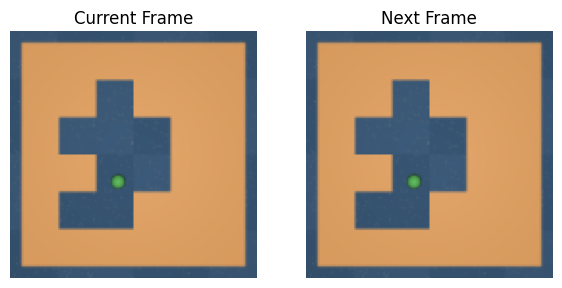

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(frame.permute(1, 2, 0).numpy())
axs[0].set_title("Current Frame")
axs[1].imshow(next_frame.permute(1, 2, 0).numpy())
axs[1].set_title("Next Frame")
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
# Encode current frame
with torch.no_grad():
    z_state, z_action, z_next_state = jepa.encode(
        state.to(device).unsqueeze(0),
        frame.to(device).unsqueeze(0),
        action.to(device).unsqueeze(0),
        next_state.to(device).unsqueeze(0),
        next_frame.to(device).unsqueeze(0)
    )
    z_frame = jepa.encoder_teacher(frame.to(device).unsqueeze(0))
    z_frame_next = jepa.encoder_teacher(next_frame.to(device).unsqueeze(0))
    # Predict next state representation
    z_next_state_pred = jepa.predict_next(z_state, z_action)
    # Decode current, next and and predicted next frame
    frame_recon = jepa.decoder(z_frame)
    next_frame_recon = jepa.decoder(z_frame_next)

In [ ]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(frame_recon.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Reconstructed Current Frame")
axs[1].imshow(next_frame_recon.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Reconstructed Next Frame")
axs[2].imshow(frame_recon.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[2].set_title("Reconstructed Predicted Next Frame")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.show()